# LINE on Wiki network

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import math
import os
import shutil
from collections import ChainMap, deque

import numpy as np
import pandas as pd
from fastdtw import fastdtw
from gensim.models import Word2Vec
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Embedding, Input, Lambda
from tensorflow.python.keras.models import Model

In [ ]:
def create_alias_table(area_ratio):
    """
    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
            (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias


def alias_sample(accept, alias):
    """
    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

In [ ]:
def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx


def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_list(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in enumerate(vertices):
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

In [ ]:
class BiasedWalker:
    def __init__(self, idx2node, temp_path):

        self.idx2node = idx2node
        self.idx = list(range(len(self.idx2node)))
        self.temp_path = temp_path
        pass

    def simulate_walks(self, num_walks, walk_length, stay_prob=0.3, workers=1, verbose=0):

        layers_adj = pd.read_pickle(self.temp_path+'layers_adj.pkl')
        layers_alias = pd.read_pickle(self.temp_path+'layers_alias.pkl')
        layers_accept = pd.read_pickle(self.temp_path+'layers_accept.pkl')
        gamma = pd.read_pickle(self.temp_path+'gamma.pkl')
        walks = []
        initialLayer = 0

        nodes = self.idx  # list(self.g.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))
        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self._exec_random_walk(layers_adj, layers_accept, layers_alias,
                                                    v, walk_length, gamma, stay_prob))
        return walks

    def _exec_random_walk(self, graphs, layers_accept, layers_alias, v, walk_length, gamma, stay_prob=0.3):
        initialLayer = 0
        layer = initialLayer

        path = []
        path.append(self.idx2node[v])

        while len(path) < walk_length:
            r = random.random()
            if(r < stay_prob):  # same layer
                v = chooseNeighbor(v, graphs, layers_alias,
                                   layers_accept, layer)
                path.append(self.idx2node[v])
            else:  # different layer
                r = random.random()
                try:
                    x = math.log(gamma[layer][v] + math.e)
                    p_moveup = (x / (x + 1))
                except:
                    print(layer, v)
                    raise ValueError()

                if(r > p_moveup):
                    if(layer > initialLayer):
                        layer = layer - 1
                else:
                    if((layer + 1) in graphs and v in graphs[layer + 1]):
                        layer = layer + 1

        return path


def chooseNeighbor(v, graphs, layers_alias, layers_accept, layer):

    v_list = graphs[layer][v]

    idx = alias_sample(layers_accept[layer][v], layers_alias[layer][v])
    v = v_list[idx]

    return v

In [ ]:
def line_loss(y_true, y_pred):
    return -K.mean(K.log(K.sigmoid(y_true*y_pred)))


def create_model(numNodes, embedding_size, order='second'):

    v_i = Input(shape=(1,))
    v_j = Input(shape=(1,))

    first_emb = Embedding(numNodes, embedding_size, name='first_emb')
    second_emb = Embedding(numNodes, embedding_size, name='second_emb')
    context_emb = Embedding(numNodes, embedding_size, name='context_emb')

    v_i_emb = first_emb(v_i)
    v_j_emb = first_emb(v_j)

    v_i_emb_second = second_emb(v_i)
    v_j_context_emb = context_emb(v_j)

    first = Lambda(lambda x: tf.reduce_sum(
        x[0]*x[1], axis=-1, keep_dims=False), name='first_order')([v_i_emb, v_j_emb])
    second = Lambda(lambda x: tf.reduce_sum(
        x[0]*x[1], axis=-1, keep_dims=False), name='second_order')([v_i_emb_second, v_j_context_emb])

    if order == 'first':
        output_list = [first]
    elif order == 'second':
        output_list = [second]
    else:
        output_list = [first, second]

    model = Model(inputs=[v_i, v_j], outputs=output_list)

    return model, {'first': first_emb, 'second': second_emb}


class LINE:
    def __init__(self, graph, embedding_size=8, negative_ratio=5, order='second',):
        """
        :param graph:
        :param embedding_size:
        :param negative_ratio:
        :param order: 'first','second','all'
        """
        if order not in ['first', 'second', 'all']:
            raise ValueError('mode must be fisrt,second,or all')

        self.graph = graph
        self.idx2node, self.node2idx = preprocess_nxgraph(graph)
        self.use_alias = True

        self.rep_size = embedding_size
        self.order = order

        self._embeddings = {}
        self.negative_ratio = negative_ratio
        self.order = order

        self.node_size = graph.number_of_nodes()
        self.edge_size = graph.number_of_edges()
        self.samples_per_epoch = self.edge_size*(1+negative_ratio)

        self._gen_sampling_table()
        self.reset_model()

    def reset_training_config(self, batch_size, times):
        self.batch_size = batch_size
        self.steps_per_epoch = (
            (self.samples_per_epoch - 1) // self.batch_size + 1)*times

    def reset_model(self, opt='adam'):

        self.model, self.embedding_dict = create_model(
            self.node_size, self.rep_size, self.order)
        self.model.compile(opt, line_loss)
        self.batch_it = self.batch_iter(self.node2idx)

    def _gen_sampling_table(self):

        # create sampling table for vertex
        power = 0.75
        numNodes = self.node_size
        node_degree = np.zeros(numNodes)  # out degree
        node2idx = self.node2idx

        for edge in self.graph.edges():
            node_degree[node2idx[edge[0]]
                        ] += self.graph[edge[0]][edge[1]].get('weight', 1.0)

        total_sum = sum([math.pow(node_degree[i], power)
                         for i in range(numNodes)])
        norm_prob = [float(math.pow(node_degree[j], power)) /
                     total_sum for j in range(numNodes)]

        self.node_accept, self.node_alias = create_alias_table(norm_prob)

        # create sampling table for edge
        numEdges = self.graph.number_of_edges()
        total_sum = sum([self.graph[edge[0]][edge[1]].get('weight', 1.0)
                         for edge in self.graph.edges()])
        norm_prob = [self.graph[edge[0]][edge[1]].get('weight', 1.0) *
                     numEdges / total_sum for edge in self.graph.edges()]

        self.edge_accept, self.edge_alias = create_alias_table(norm_prob)

    def batch_iter(self, node2idx):

        edges = [(node2idx[x[0]], node2idx[x[1]]) for x in self.graph.edges()]

        data_size = self.graph.number_of_edges()
        shuffle_indices = np.random.permutation(np.arange(data_size))
        # positive or negative mod
        mod = 0
        mod_size = 1 + self.negative_ratio
        h = []
        t = []
        sign = 0
        count = 0
        start_index = 0
        end_index = min(start_index + self.batch_size, data_size)
        while True:
            if mod == 0:

                h = []
                t = []
                for i in range(start_index, end_index):
                    if random.random() >= self.edge_accept[shuffle_indices[i]]:
                        shuffle_indices[i] = self.edge_alias[shuffle_indices[i]]
                    cur_h = edges[shuffle_indices[i]][0]
                    cur_t = edges[shuffle_indices[i]][1]
                    h.append(cur_h)
                    t.append(cur_t)
                sign = np.ones(len(h))
            else:
                sign = np.ones(len(h))*-1
                t = []
                for i in range(len(h)):

                    t.append(alias_sample(
                        self.node_accept, self.node_alias))

            if self.order == 'all':
                yield ([np.array(h), np.array(t)], [sign, sign])
            else:
                yield ([np.array(h), np.array(t)], [sign])
            mod += 1
            mod %= mod_size
            if mod == 0:
                start_index = end_index
                end_index = min(start_index + self.batch_size, data_size)

            if start_index >= data_size:
                count += 1
                mod = 0
                h = []
                shuffle_indices = np.random.permutation(np.arange(data_size))
                start_index = 0
                end_index = min(start_index + self.batch_size, data_size)

    def get_embeddings(self,):
        self._embeddings = {}
        if self.order == 'first':
            embeddings = self.embedding_dict['first'].get_weights()[0]
        elif self.order == 'second':
            embeddings = self.embedding_dict['second'].get_weights()[0]
        else:
            embeddings = np.hstack((self.embedding_dict['first'].get_weights()[
                                   0], self.embedding_dict['second'].get_weights()[0]))
        idx2node = self.idx2node
        for i, embedding in enumerate(embeddings):
            self._embeddings[idx2node[i]] = embedding

        return self._embeddings

    def train(self, batch_size=1024, epochs=1, initial_epoch=0, verbose=1, times=1):
        self.reset_training_config(batch_size, times)
        hist = self.model.fit_generator(self.batch_it, epochs=epochs, initial_epoch=initial_epoch, steps_per_epoch=self.steps_per_epoch,
                                        verbose=verbose)

        return hist

In [ ]:
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


class Classifier(object):

    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = np.random.get_state()

        training_size = int(train_precent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test, Y_test)


def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

In [ ]:
!wget -q --show-progress https://github.com/shenweichen/GraphEmbedding/raw/master/data/wiki/wiki_labels.txt
!wget -q --show-progress https://github.com/shenweichen/GraphEmbedding/raw/master/data/wiki/Wiki_edgelist.txt

wiki_labels.txt.3   100%[===================>]  16.24K  --.-KB/s    in 0.002s  
Wiki_edgelist.txt.1 100%[===================>] 158.21K  --.-KB/s    in 0.06s   


Epoch 5/50
97/97 - 1s - loss: 0.5150
Epoch 6/50
97/97 - 1s - loss: 0.4215
Epoch 7/50
97/97 - 1s - loss: 0.3872
Epoch 8/50
97/97 - 1s - loss: 0.3463
Epoch 9/50
97/97 - 1s - loss: 0.3210
Epoch 10/50
97/97 - 1s - loss: 0.2968
Epoch 11/50
97/97 - 1s - loss: 0.2732
Epoch 12/50
97/97 - 1s - loss: 0.2520
Epoch 13/50
97/97 - 1s - loss: 0.2377
Epoch 14/50
97/97 - 1s - loss: 0.2111
Epoch 15/50
97/97 - 1s - loss: 0.1952
Epoch 16/50
97/97 - 1s - loss: 0.1802
Epoch 17/50
97/97 - 1s - loss: 0.1648
Epoch 18/50
97/97 - 1s - loss: 0.1550
Epoch 19/50
97/97 - 1s - loss: 0.1460
Epoch 20/50
97/97 - 1s - loss: 0.1331
Epoch 21/50
97/97 - 1s - loss: 0.1234
Epoch 22/50
97/97 - 1s - loss: 0.1151
Epoch 23/50
97/97 - 1s - loss: 0.1091
Epoch 24/50
97/97 - 1s - loss: 0.1029
Epoch 25/50
97/97 - 1s - loss: 0.0995
Epoch 26/50
97/97 - 1s - loss: 0.0916
Epoch 27/50
97/97 - 1s - loss: 0.0888
Epoch 28/50
97/97 - 1s - loss: 0.0837
Epoch 29/50
97/97 - 1s - loss: 0.0802
Epoch 30/50
97/97 - 1s - loss: 0.0765
Epoch 31/50
97/97

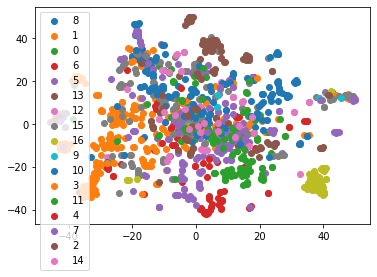

In [ ]:
DATA_GRAPH = 'wiki_labels.txt'
DATA_EDGES = 'Wiki_edgelist.txt'


def evaluate_embeddings(embeddings):
    X, Y = read_node_label(DATA_GRAPH, skip_head=True)
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings,):
    X, Y = read_node_label(DATA_GRAPH, skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    G = nx.read_edgelist('Wiki_edgelist.txt',
                         create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

    model = LINE(G, embedding_size=128, order='second')
    model.train(batch_size=1024, epochs=50, verbose=2)
    embeddings = model.get_embeddings()

    evaluate_embeddings(embeddings)
    plot_embeddings(embeddings)